## Stroke Prediction




#### 1. Data importation and structure

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
mycolors = ['#FF8552','#297373']

In [2]:
!pip install imblearn

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
# Read the csv file to a dataframe

stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

print(f'Number of Rows: {stroke.shape[0]} rows')
print(f'Number of Features: {stroke.shape[1]} features')
print(f'A list of the features: {stroke.columns.tolist()}')
print('===================================')
stroke.head()

Number of Rows: 5110 rows
Number of Features: 12 features
A list of the features: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We have the records of __5110__ patients in our data. <br>
The data has 11 predictors/independent variables that will be used to predict the dependent variable; __stroke__.


In [4]:
# More information about the columns

print(stroke.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


All columns are in the right format for data analysis. <br>
We have missing values in the bmi column. We need to analyze the data first, in order to understand how to deal with the missing values.


#### 2. Exploratory Data Analysis

In [5]:
# statistical summary of the numerical features

stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# make a copy of the dataset

stroke_copy =  stroke.copy(deep=True)

# Create a function to convert the stroke feature from integer to categorical for EDA

def to_cat(val):
    if val == 1:
        return 'Stroke'
    else:
        return 'No Stroke'

# apply the function to the data

stroke_copy['class'] = stroke_copy['stroke'].apply(to_cat)
stroke_copy.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,class
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,Stroke
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Stroke
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Stroke
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Stroke


In [7]:
# drop the stroke column 
stroke_copy.drop('stroke', axis=1, inplace=True)
print(stroke_copy['class'].unique())

['Stroke' 'No Stroke']


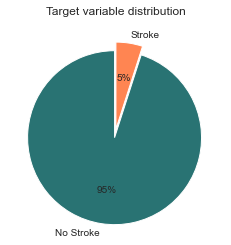

In [8]:
# Class distribution

ax = stroke_copy.groupby('class').sum()['id'].plot.pie(autopct='%1.0f%%', 
                                                  explode=(0.1,0), 
                                                  colors=['#297373','#FF8552'], 
                                                  startangle=90)
ax.set_ylabel('')
plt.title("Target variable distribution")
plt.show()

The dependent variable is highly imbalance data.

###  2.1 Univariate Analysis for the Continous Variables
#### 2.1.1 Age

In [9]:
# function to plot univariate features as we'll plotting for more than one feature

def univariate_plot(df,kind,col):
    if kind == 'boxplot':
        return sns.boxplot(x=df[col])
    elif kind == 'histplot':
        return sns.histplot(data=df, x=col, kde=False)
    else:
        return sns.kdeplot(data=df, x=col, fill=True)
    
    plt.figure(figsize=(12,6))
    plt.show()

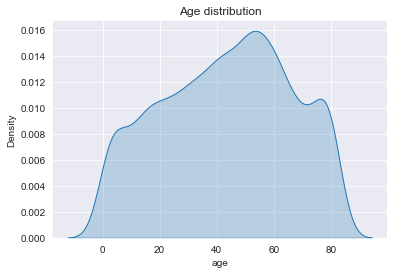

In [10]:
# Density plot for Age

univariate_plot(stroke_copy, 'kdeplot', 'age')
plt.title("Age distribution")
plt.show()

Average age: 43.23 years


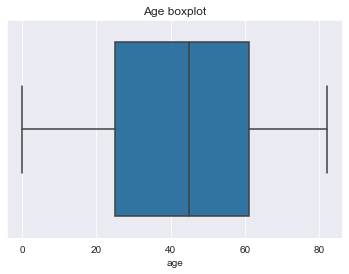

In [11]:
# Boxplot for age
print("Average age:", round(stroke_copy["age"].mean(),2), "years")
univariate_plot(stroke_copy, 'boxplot', 'age')
plt.title("Age boxplot")
plt.show()

In [12]:
def group_data(row):
    '''
    Function to group ages, BMI, and average glucose levels 
    according to CDC guidelines.
    '''
    # Age groups
    if row['age'] <= 1:
        age_group = 'Infants'
    elif row['age'] <= 12:
        age_group = 'Children'
    elif row['age'] <= 17:
        age_group = 'Teenager'
    elif row['age'] <= 44:
        age_group = 'Adult'
    elif row['age'] <= 60:
        age_group = 'Middle_Aged'
    else:
        age_group = 'Older_Adult'

    # BMI groups
    if row['bmi'] < 18.5:
        bmi_group = 'Underweight'
    elif row['bmi'] < 24.9:
        bmi_group = 'Healthy Weight'
    elif row['bmi'] < 29.9:
        bmi_group = 'Overweight'
    elif row['bmi'] < 40:
        bmi_group = 'Obesity'
    else:
        bmi_group = 'Severe Obesity'

    # Glucose groups
    if row['avg_glucose_level'] < 100:
        glucose_group = 'Normal'
    elif row['avg_glucose_level'] <= 125:
        glucose_group = 'Prediabetes'
    else:
        glucose_group = 'Diabetes'

    # Return all groups
    return pd.Series({'age_group': age_group,
                      'BMI_class': bmi_group,
                      'glucose_class': glucose_group})

# Apply the function to the data
stroke_copy[['age_group', 'BMI_class', 'glucose_class']] = stroke_copy.apply(group_data, axis=1)

# View the updated data
stroke_copy.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,class,age_group,BMI_class,glucose_class
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,Stroke,Older_Adult,Obesity,Diabetes
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,Stroke,Older_Adult,Severe Obesity,Diabetes
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,Stroke,Older_Adult,Obesity,Prediabetes
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,Stroke,Middle_Aged,Obesity,Diabetes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,Stroke,Older_Adult,Healthy Weight,Diabetes


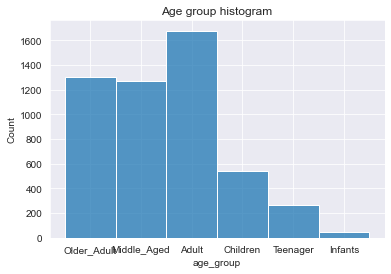

In [13]:
univariate_plot(stroke_copy, 'histplot', 'age_group')
plt.title("Age group histogram")
plt.show()

__Observations:__ 
* Most patients in the dataset are adults with no outliers i.e there's no age out of the ordinary.
* There are more adults within the dataset.

#### 2.1.2 Glucose Level

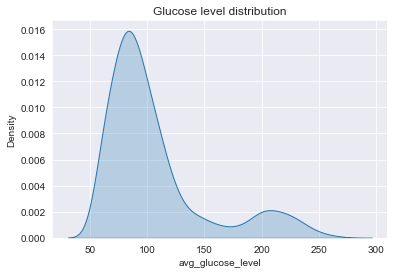

In [14]:
# Density plot for glucose level

univariate_plot(stroke_copy, 'kdeplot', 'avg_glucose_level')
plt.title("Glucose level distribution")
plt.show()

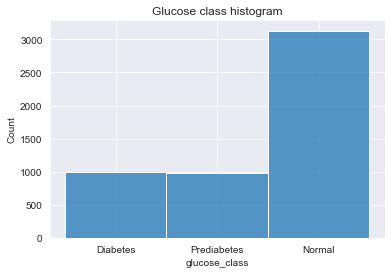

In [15]:
univariate_plot(stroke_copy, 'histplot', 'glucose_class')
plt.title("Glucose class histogram")
plt.show()

AVG Glucose Level Median: 91.88499999999999


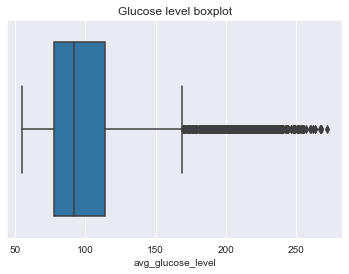

In [16]:
print("AVG Glucose Level Median:", stroke_copy['avg_glucose_level'].median())

univariate_plot(stroke_copy, 'boxplot', 'avg_glucose_level')
plt.title("Glucose level boxplot")
plt.show()

__Observations:__ 
* The average glucose level in the data is right skewed. 
* Most patients in the dataset has a normal average glucose level.
* The outliers in the boxplot are not really outliers, the values are real values, and they depict patients with diabetes


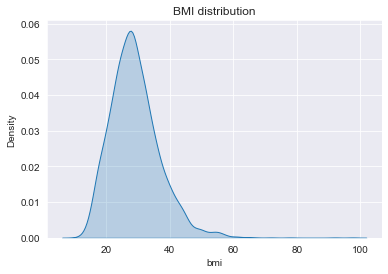

In [17]:
univariate_plot(stroke_copy, 'kdeplot', 'bmi')
plt.title("BMI distribution")
plt.show()

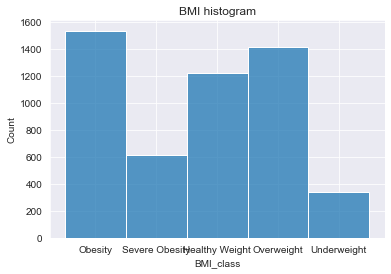

In [18]:
univariate_plot(stroke_copy, 'histplot', 'BMI_class')
plt.title("BMI histogram")
plt.show()

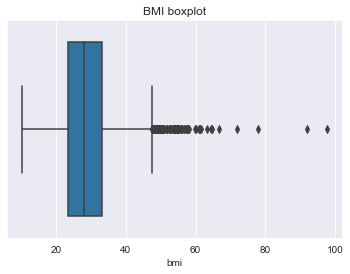

In [19]:
univariate_plot(stroke_copy, 'boxplot', 'bmi')
plt.title("BMI boxplot")
plt.show()

__Observations:__
* Most patients aren't healthy in terms of BMI. There are more obesed and overweight patients than the ones with normal weight.
* There are outliers in the BMI column as well.



###  2.2 Univariate Analysis for the Categorical Variables

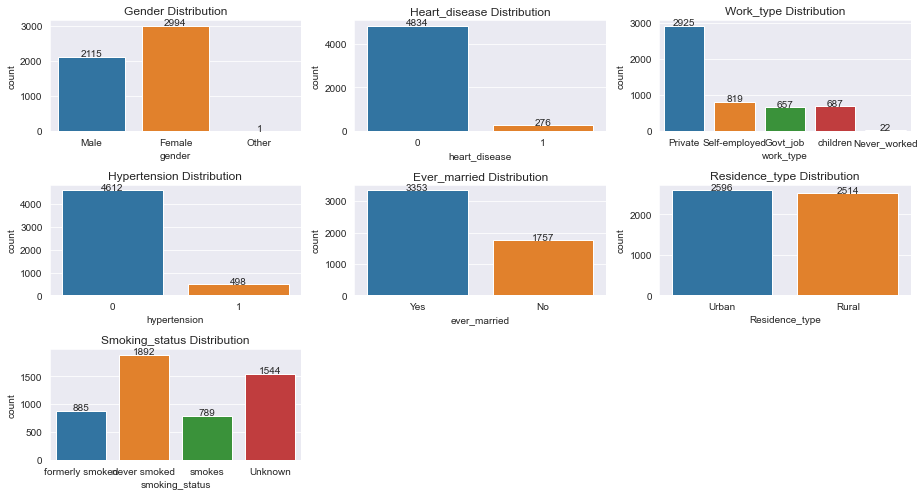

In [20]:
# create the figure and subplots
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(13, 7))
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# define the attributes to display and their corresponding subplot indices
attributes = ["gender", "heart_disease", "work_type", "hypertension", "ever_married", "Residence_type", "smoking_status"]
subplot_indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0)]

# use a loop to create count plots for each attribute
for idx, attr in enumerate(attributes):
    row_idx, col_idx = subplot_indices[idx]
    sns.countplot(x=stroke_copy[attr], ax=axes[row_idx, col_idx])
    for patch in axes[row_idx, col_idx].patches:
        axes[row_idx, col_idx].text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 5, '{:.0f}'.format(patch.get_height()), ha='center')
    axes[row_idx, col_idx].set_title(f"{attr.capitalize()} Distribution")

# adjust the spacing between subplots
plt.tight_layout()

# display the figure
plt.show()

__Observations:__ 
* We have more female in the dataset. Also there's a single patient whose gender is "Other".
* Since female is the mode of the gender feature, the patient with 'Other' will be re-categorised to female. This way, we'll have just 2 categories in the column.
* Most of the patients in the data are healthy in terms of heart disease.
* More than 50% of the patients work in the private sector.
* With the assumption that children can't work/never worked, we can move the instances of "children" category to the "Never_worked" category.
* 90% of the patients are not hypertensive.
* We have more patients who have married at one stage in their life than those who haven't.
* We have almost equal amount of patients living in the Rural and Urban areas.

In [21]:
# Checking to see details of the patient categorised as "Other"
stroke_copy[stroke_copy["gender"] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,class,age_group,BMI_class,glucose_class
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,No Stroke,Adult,Healthy Weight,Diabetes


In [22]:
# Checking to count the number of patients who are less than 18 with the "Unknown" smoking status.

stroke_copy[(stroke_copy.smoking_status == 'Unknown') & (stroke_copy.age < 18)].shape[0]

682

__Observation:__
* We have more patients that have never smoked in the dataset.
* We also have lots of "unknown" smoking status. Since we have 682 patients less than 18, we can make an assumption that they never smoked.

## 2.3 Multivariate Analysis

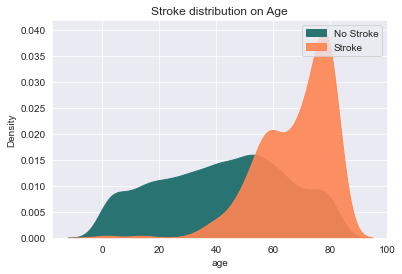

In [23]:
# Target variable distribution on age

fig,ax = plt.subplots()
sns.kdeplot(data = stroke_copy[stroke_copy['class'] == 'No Stroke'], 
            x='age', ax=ax, fill=True, alpha=1, color='#297373')

sns.kdeplot(data = stroke_copy[stroke_copy['class'] == 'Stroke'], 
            x='age', ax=ax, fill=True,  alpha=0.9, color='#FF8552')
ax.legend(['No Stroke', 'Stroke'])
plt.title("Stroke distribution on Age")
plt.show()

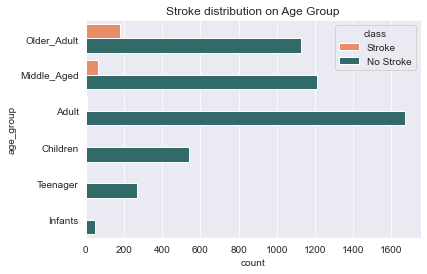

In [24]:
# Target variable distribution on age group
sns.countplot(data=stroke_copy, y='age_group', 
              hue='class', palette=mycolors)
plt.title("Stroke distribution on Age Group")
plt.show()

__Observation:__
* More patients that are older than 40 years seems to have stroke with little number of patients less than 40 years having stroke.

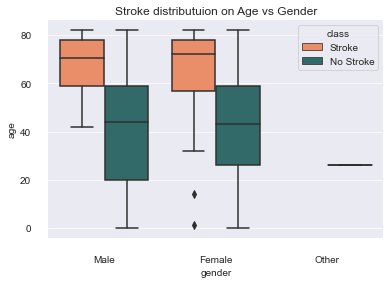

In [25]:
# Gender stroke distribution

sns.boxplot(x="gender", y="age",
            hue="class", palette=mycolors,
            data=stroke_copy)
sns.despine(offset=10, trim=True)
plt.title("Stroke distributuion on Age vs Gender")
plt.show()

In [26]:
# Checking the details of the two outliers in the above plot
stroke_copy[(stroke_copy.gender == 'Female') & (stroke_copy.age < 20) & (stroke_copy['class'] == 'Stroke')]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,class,age_group,BMI_class,glucose_class
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,Stroke,Children,Severe Obesity,Normal
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,Stroke,Teenager,Obesity,Normal


__Observations:__
* The males in the data tend to have stroke at age over 40, while women tends to have stroke from age around 30s.
* There are two children (less than 18 years) that have stroke.

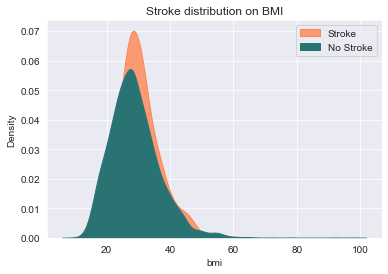

In [27]:
# Target variable distribution on BMI

fig,ax = plt.subplots()

sns.kdeplot(data = stroke_copy[stroke_copy['class'] == 'Stroke'], 
            x='bmi', color='#FF8552', fill=True, alpha=0.8, ax=ax)

sns.kdeplot(data = stroke_copy[stroke_copy['class'] == 'No Stroke'], 
            x='bmi', color='#297373', fill=True, alpha=1, ax=ax)
ax.legend(['Stroke','No Stroke'])
plt.title("Stroke distribution on BMI")
plt.show()

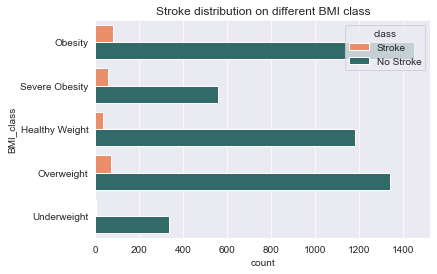

In [28]:
# Plot BMI class count with Stroke

sns.countplot(data=stroke_copy, y='BMI_class', 
              hue='class', palette=mycolors)
plt.title("Stroke distribution on different BMI class")
plt.show()

__Observation:__
* The underweight patient are the least class that has stroke, followed by the healthy weight class. 
* Stroke seems to occur in patients with overweight, obesity, and class III obesity.

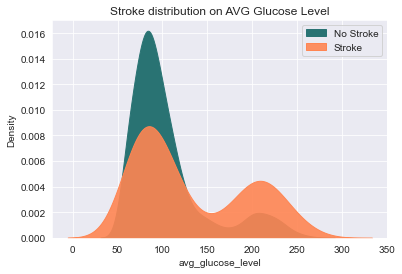

In [29]:
# Target variable distribution on AVG Glucose Level

fig,ax = plt.subplots()
sns.kdeplot(data = stroke_copy[stroke_copy['class'] == 'No Stroke'], 
            x='avg_glucose_level', ax=ax, fill=True, alpha=1, color='#297373')

sns.kdeplot(data = stroke_copy[stroke_copy['class'] == 'Stroke'], 
            x='avg_glucose_level', ax=ax, fill=True,  alpha=0.9, color='#FF8552')
ax.legend(['No Stroke', 'Stroke'])
plt.title("Stroke distribution on AVG Glucose Level")
plt.show()

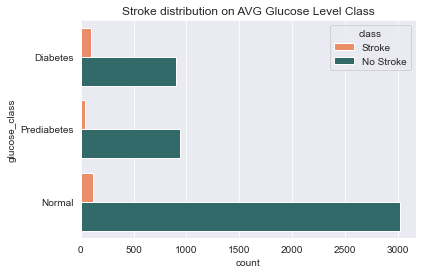

In [30]:
sns.countplot(data=stroke_copy, y='glucose_class', 
              hue='class', palette=mycolors)
plt.title("Stroke distribution on AVG Glucose Level Class")
plt.show()

__Observation:__ <br>
We have more patients with normal glucose level, and very few of them have stroke. <br> The patients with prediabetes and diabetes that has stroke are lesser than those with normal glucose level.

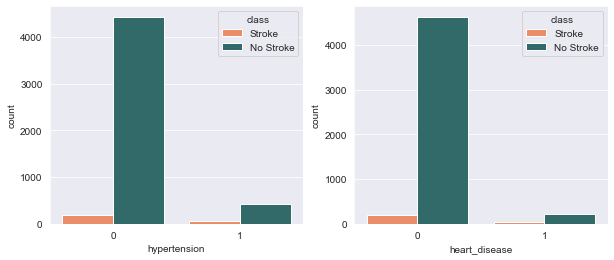

In [31]:
# Stroke on Hypertension and Heart disease

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(10,4))
sns.countplot(data=stroke_copy, x='hypertension', 
              hue='class', palette=mycolors, ax=ax0)

sns.countplot(data=stroke_copy, x='heart_disease', 
              hue='class', palette=mycolors, ax=ax1)
plt.show()

__Observation:__
* Patients who does not have hypertension have stroke than those that does not have hypertension.
* Also, patients who does not have heart disease have stroke than those that does not have heart disease.

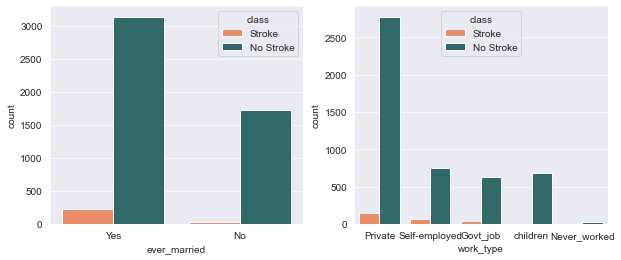

In [32]:
# Stroke on marital status and type of work

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(10,4))
sns.countplot(data=stroke_copy, x='ever_married', 
              hue='class', palette=mycolors, ax=ax0)

sns.countplot(data=stroke_copy, x='work_type', 
              hue='class', palette=mycolors, ax=ax1)
plt.show()

__Observation:__
* Patients who are married at a point in their life have stroke than those that have never married.
* More patients from the private sector has stroke, followed by the self employed, and govt workers respectively.
* More insights could have been determined if we are able to know the industry these patients work.

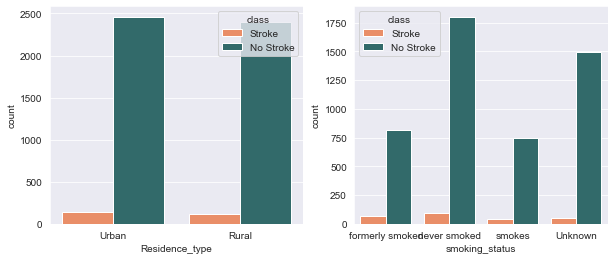

In [33]:
# Stroke on type of residence and smoking status

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(10,4))
sns.countplot(data=stroke_copy, x='Residence_type', 
              hue='class', palette=mycolors, ax=ax0)

sns.countplot(data=stroke_copy, x='smoking_status', 
              hue='class', palette=mycolors, ax=ax1)
plt.show()

__Observation:__
* Patients with stroke is almost evenly spread across the rural types.
* Combination of patients that formely smoked and those that smokes have stroke than those that never smoked.
* We also have lots of unknown smoking status that has stroke

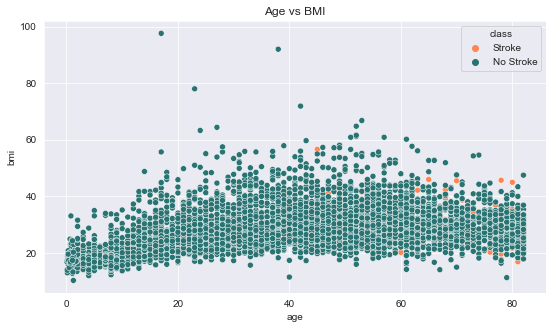

In [34]:
# Age vs BMI
fig,ax=plt.subplots(figsize=(9,5))
sns.scatterplot(data=stroke_copy, x="age", y="bmi", 
                hue='class', palette=mycolors)
plt.title('Age vs BMI')
plt.show()

__Observation:__ Most of the patients have BMI under 40, and stroke occurs more in patients over 60 years old.

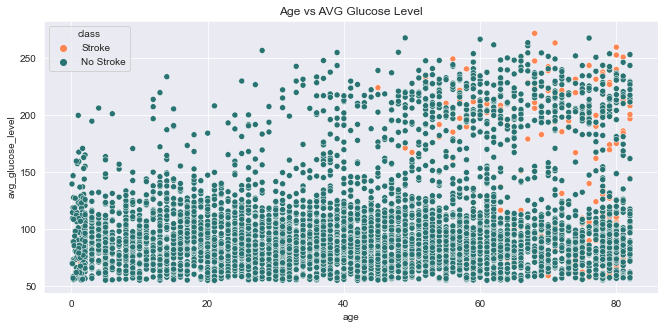

In [35]:
# Age vs Glucose Level
fig,ax=plt.subplots(figsize=(11,5))
sns.scatterplot(data=stroke_copy, x="age", y="avg_glucose_level", 
                hue='class', palette=mycolors)
plt.title('Age vs AVG Glucose Level')
plt.show()

Patients with average glucose level higher than 150 and over 60 years old tends to have stroke.

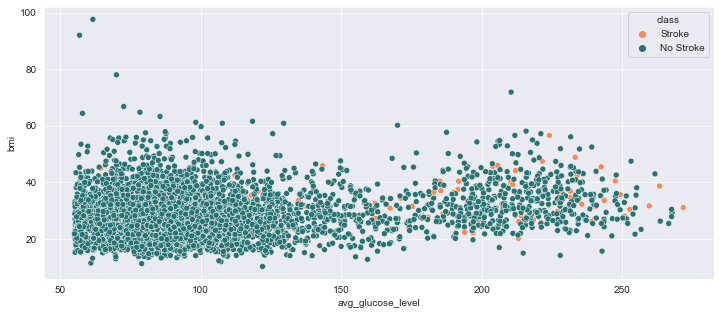

In [36]:
# BMI vs Glucose Level
fig,ax=plt.subplots(figsize=(12,5))
sns.scatterplot(data=stroke_copy, y="bmi", x="avg_glucose_level", 
                hue='class', palette=mycolors)
plt.show()

Most people have BMI less than 60, stroke tends to happen with the ones that have average glucose level over 150.

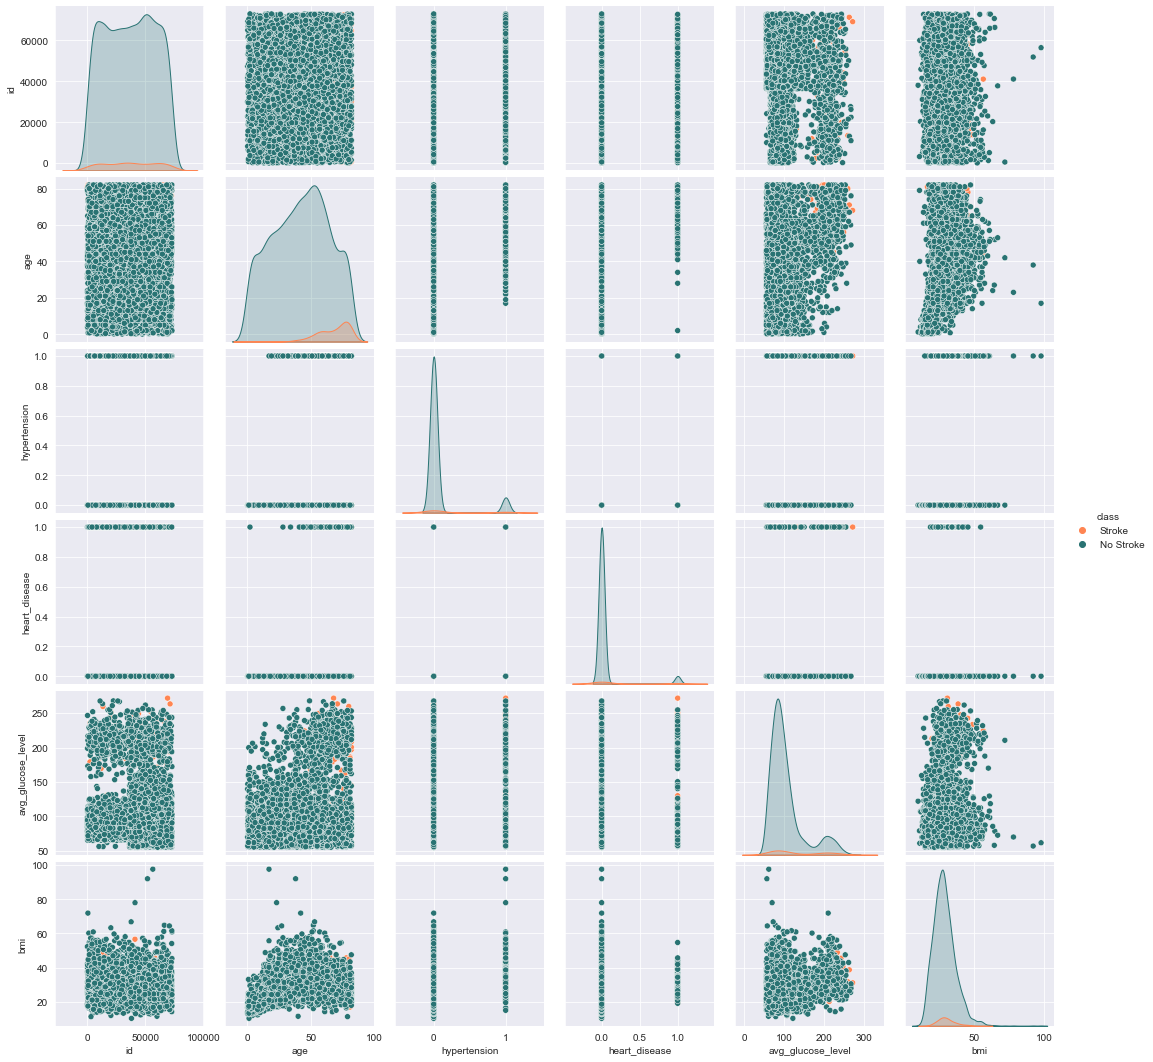

In [37]:
# Scatter plot matrix of the numerical columns

sns.pairplot(stroke_copy, hue="class", palette=mycolors)
plt.show()

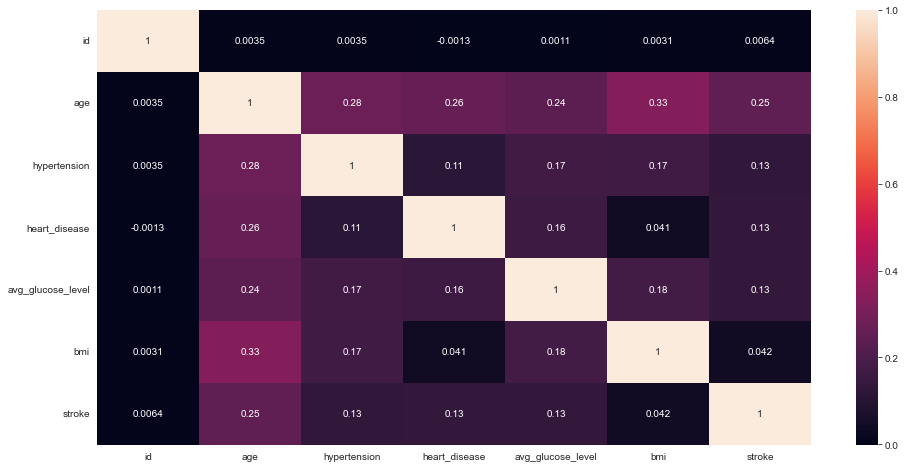

In [38]:
# Standard correlation coefficients of features
plt.figure(figsize=(16,8))
sns.heatmap(stroke.corr(),annot=True);

__Observation:__
BMI is the least correlated with stroke, and age is the most correlated to stroke amongs the numerical features.

### 3.0 Data Preparation for Machine Learning

In [39]:
# Dropping the ID column

stroke.drop(['id'], axis=1, inplace=True)
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


#### 3.1 Handling missing values in the BMI column.

In [40]:
# Statistics of the BMI column
stroke.bmi.describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

Since we have right skewed distribution in the column, we are going to use the median to fill, the missing values.

In [41]:
# fill the missing values with median BMI
stroke.fillna(value=stroke.bmi.median(), axis=1, inplace=True)
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             5110 non-null   object
 1   age                5110 non-null   object
 2   hypertension       5110 non-null   object
 3   heart_disease      5110 non-null   object
 4   ever_married       5110 non-null   object
 5   work_type          5110 non-null   object
 6   Residence_type     5110 non-null   object
 7   avg_glucose_level  5110 non-null   object
 8   bmi                5110 non-null   object
 9   smoking_status     5110 non-null   object
 10  stroke             5110 non-null   object
dtypes: object(11)
memory usage: 439.3+ KB


In [42]:
# Changing the 'Other' value in the gender column to 'Female'

print("Before Change: ", stroke.at[3116, 'gender'])

stroke.at[3116, 'gender'] = 'Female'

print("After Change: ", stroke.at[3116, 'gender'])

Before Change:  Other
After Change:  Female


#### 3.2 Changing the values of people under 18 with 'Unknown' smoking status to 'never smoked'

In [43]:
print("Initial Count of Unknown Smoking Status:", stroke[stroke['smoking_status'] == 'Unknown'].shape[0])

# Changing the values to 'never smoked' for the under 18s
stroke.loc[stroke['age'] < 18, 'smoking_status'] = 'never smoked'

print("Current Count of Unknown Smoking Status:", stroke[stroke['smoking_status'] == 'Unknown'].shape[0])

Initial Count of Unknown Smoking Status: 1544
Current Count of Unknown Smoking Status: 862


### Changing the "children" under work_type to "Never_worked"
Using the assumption that children doesn't work.

In [44]:

# Changing the values to 'Never_worked' from 'children'
stroke.loc[stroke['work_type'] == 'children', 'work_type'] = 'Never_worked'

# View the counts of values in the 'work_type' column
stroke.work_type.value_counts()

Private          2925
Self-employed     819
Never_worked      709
Govt_job          657
Name: work_type, dtype: int64

### 3.3 Binning Age, BMI, and Glucose Level into groups

In [45]:
# Using the function created earlier for the bins

stroke[['age_group', 'BMI_class', 'glucose_class']] = stroke.apply(group_data, axis=1)
stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,BMI_class,glucose_class
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Older_Adult,Obesity,Diabetes
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,Older_Adult,Overweight,Diabetes
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Older_Adult,Obesity,Prediabetes
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Middle_Aged,Obesity,Diabetes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Older_Adult,Healthy Weight,Diabetes


### 3.4 Encoding Categorical Data 

* Label Encoding will be used for the ordinal features so we can preserve the order of the categories
* OneHot Encoding will be used for other nominal features since there are no inherent order in the categories. <br> The Scikit-Learn library will be used to perform these operations.

In [46]:
# Importing LabelEncoder and OneHot Encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Creating a re-usable function to perform the operations

def label_encode(df, col_list):
    """
    Encodes specified columns in a dataframe using LabelEncoder
    """
    le = LabelEncoder()
    
    for col in col_list:
        df[col] = le.fit_transform(df[col])
    
    return df

def onehot_encode(df, col_list):
    """
    Encodes specified columns in a dataframe using OneHotEncoder
    """
    ohe = OneHotEncoder()
    
    ohe_result = ohe.fit_transform(df[col_list])
    ohe_df = pd.DataFrame(ohe_result.toarray(), columns=ohe.get_feature_names_out(col_list))
    
    df = pd.concat([df,ohe_df], axis=1)
    df = df.drop(columns=col_list, axis=1)
    
    return df

In [47]:
# Encoding the ordinal features with the LabelEncoder
label_encode(stroke, ['age_group', 'BMI_class', 'glucose_class'])

# Encoding the nominal features with the OneHot Encoder
stroke = onehot_encode(stroke, ['work_type', 'smoking_status', 'gender', 'ever_married', 'Residence_type'])

stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   object 
 1   hypertension                    5110 non-null   object 
 2   heart_disease                   5110 non-null   object 
 3   avg_glucose_level               5110 non-null   object 
 4   bmi                             5110 non-null   object 
 5   stroke                          5110 non-null   object 
 6   age_group                       5110 non-null   int32  
 7   BMI_class                       5110 non-null   int32  
 8   glucose_class                   5110 non-null   int32  
 9   work_type_Govt_job              5110 non-null   float64
 10  work_type_Never_worked          5110 non-null   float64
 11  work_type_Private               5110 non-null   float64
 12  work_type_Self-employed         51

In [48]:
# Ensuring all columns are numeric

# Columns that are type 'object'
cols = stroke.columns[stroke.dtypes.eq('object')]

# convert the columns to numeric
stroke[cols] = stroke[cols].apply(pd.to_numeric, errors='coerce')

stroke.dtypes

age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
age_group                           int32
BMI_class                           int32
glucose_class                       int32
work_type_Govt_job                float64
work_type_Never_worked            float64
work_type_Private                 float64
work_type_Self-employed           float64
smoking_status_Unknown            float64
smoking_status_formerly smoked    float64
smoking_status_never smoked       float64
smoking_status_smokes             float64
gender_Female                     float64
gender_Male                       float64
ever_married_No                   float64
ever_married_Yes                  float64
Residence_type_Rural              float64
Residence_type_Urban              float64
dtype: object

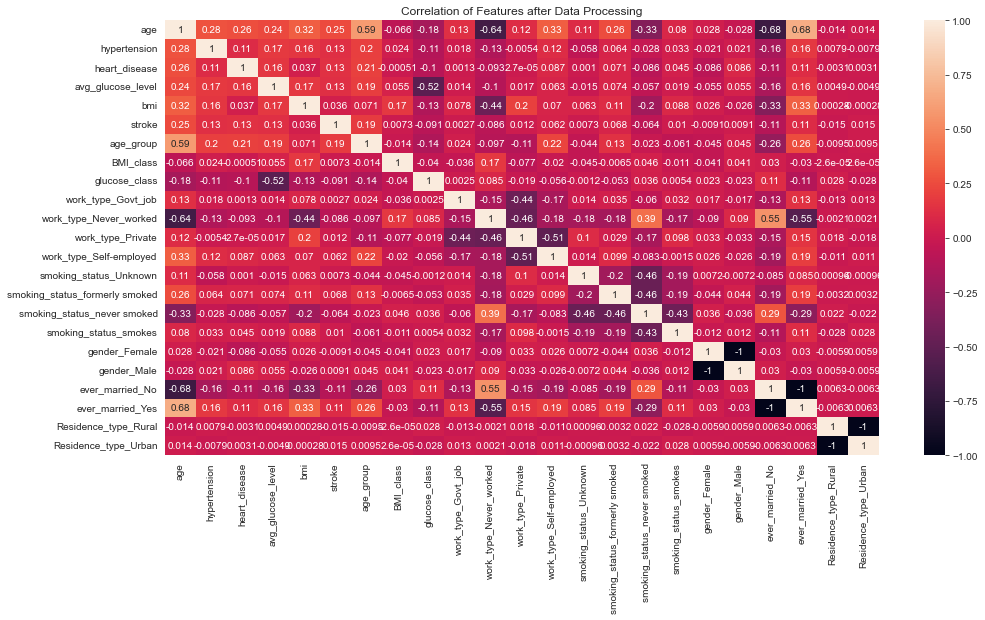

In [49]:
# Standard correlation coefficients of features after Processing
plt.figure(figsize=(16,8))
sns.heatmap(stroke.corr(),annot=True);
plt.title("Correlation of Features after Data Processing")
plt.show()

## 3.5 Data Split - 70:30 Ratio

In [50]:
from sklearn.model_selection import train_test_split

# input features
X = stroke.drop(['stroke'], axis=1)

# Output Label
y = stroke['stroke']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)


print("X_train:", X_train.shape)
print("X_test:",X_test.shape)
print("y_train: \n",y_train.value_counts())
print("y_test: \n",y_test.value_counts())

X_train: (3577, 22)
X_test: (1533, 22)
y_train: 
 0    3403
1     174
Name: stroke, dtype: int64
y_test: 
 0    1458
1      75
Name: stroke, dtype: int64


## 3.6 Feature Selection

[ True  True False  True  True  True  True False False False  True False
 False False  True False False  True False False  True False]
[ 1  1  3  1  1  1  1  2 11 13  1  5  7  4  1 10  8  1  9 12  1  6]


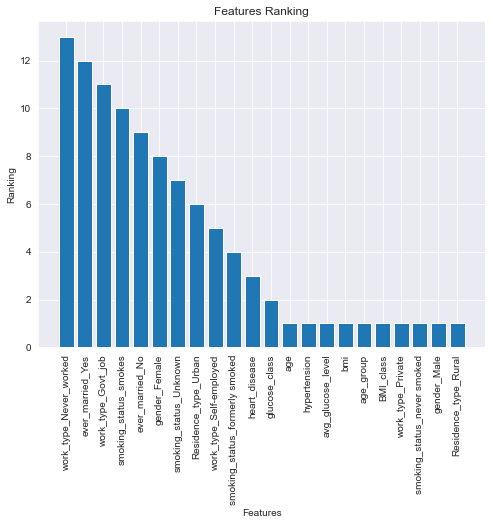

In [51]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier



# create Decision Tree object
rf = RandomForestClassifier(random_state=42)

# create RFE model and select top 10 features
rfe = RFE(rf, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

# sort the ranking in descending order
ranked_cols = sorted(zip(X_train.columns, rfe.ranking_), key=lambda x: x[1], reverse=True)

# visualize the selected features
plt.figure(figsize=(8,6))
plt.title("Features Ranking")
plt.xlabel("Features")
plt.ylabel("Ranking")
plt.bar(range(len(rfe.ranking_)), [ranked_col[1] for ranked_col in ranked_cols])
plt.xticks(range(len(rfe.ranking_)), [ranked_col[0] for ranked_col in ranked_cols], rotation=90)
plt.show()

In [52]:
# transform the data using the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

### 3.7 Data Scaling -  Standardisation

In [53]:
# Putting the data into similar scale using the standardisation method

from sklearn.preprocessing import StandardScaler

# Instantiate the standard scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train_rfe)
X_test_scaled = scaler.transform(X_test_rfe)


### 3.8 OverSampling the Train Data with SMOTE
Synthetic Minority Over-samling Technique (SMOTE) is a technique for oversampling imbalanced data by generating sythentic samples for the minority class. <br>


In [54]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print the distribution of the original and resampled sets
print("Original set distribution: \n", y_train.value_counts())
print("\nResampled set distribution: \n", pd.Series(y_train_resampled).value_counts())


Original set distribution: 
 0    3403
1     174
Name: stroke, dtype: int64

Resampled set distribution: 
 0    3403
1    3403
Name: stroke, dtype: int64


## 4.0 Training Binary Classification Models & Evaluating their Performance

In [55]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate, learning_curve
from sklearn.metrics import auc, roc_auc_score, confusion_matrix, roc_curve, classification_report

# Create a function to display results of models
def display_metrics(y_true, y_pred):
    """
    Displays the confusion matrix and classification report for given inputs.
    
    """
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    
    print("Confusion Matrix:\n ")
    print(cm)
    print('\n')
    print("Classification Report:\n ")
    print(cr)

### 4.1 LOGISTIC REGRESSION

In [56]:
from sklearn.linear_model import LogisticRegression

# Train LR model and evaluate using 10-fold cross validation
lr = LogisticRegression(random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# F1-scores of the 10 folds
scores = cross_val_score(lr, X_train_resampled, y_train_resampled, scoring='f1', cv=cv)

print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Cross-validation scores:
F1-score: [0.82476943 0.80758808 0.80932785 0.81626928 0.81438849 0.81830065
 0.78197674 0.79525223 0.82180851 0.81043956]
Average F1-score: 0.81


In [57]:
# Tuning the hyperparameters of the LR model to identify the best parameters.

from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.1, 1, 10, 100],
              'solver': ['liblinear', 'saga']}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(lr, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [58]:
# Use the best parameters for LR model

lr_best = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(lr_best, X_train_resampled, y_train_resampled, scoring='f1', cv=cv)

print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Cross-validation scores:
F1-score: [0.82368421 0.80592992 0.80984952 0.81792717 0.81609195 0.81818182
 0.78550725 0.79468242 0.82119205 0.81207133]
Average F1-score: 0.81


There are no visible changes in the results after using the best hyperparameters. <br>The next thing is to evaluate the model on the test set.

In [59]:

# Fit & predict the LR model on the train set
lr_best.fit(X_train_resampled, y_train_resampled)
y_pred = lr_best.predict(X_train_resampled)

# Display metrics
print("LR Train metrics: \n")
display_metrics(y_train_resampled, y_pred)

LR Train metrics: 

Confusion Matrix:
 
[[2491  912]
 [ 457 2946]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      3403
           1       0.76      0.87      0.81      3403

    accuracy                           0.80      6806
   macro avg       0.80      0.80      0.80      6806
weighted avg       0.80      0.80      0.80      6806



In [60]:
# Predict on the test set
y_pred = lr_best.predict(X_test_scaled)


# Display metrics
print("Logistic Regression Test Metrics \n")
display_metrics(y_test, y_pred)

Logistic Regression Test Metrics 

Confusion Matrix:
 
[[1041  417]
 [  10   65]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.87      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.79      0.53      1533
weighted avg       0.95      0.72      0.80      1533



__Observation:__
The model's performance performance in terms of accuracy is fair. A good Recall and poor Precision resulted in the poor F1-score. <br>
The model predicted 397 non stroke as stroke which resulted in the poor precision. Since we are looking to predict a medical diagnosis, it's important to have an very good Recall and Precision.

### 4.2 K-NEAREST NEIGHBOUR (KNN)

In [61]:
from sklearn.neighbors import KNeighborsClassifier

# Range of K values to try
k_range = list(range(1, 31))

# Search for best K
param_grid = {'n_neighbors': k_range}
knn = KNeighborsClassifier()
kf = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(knn, param_grid, cv=kf)
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve best K
best_k = grid_search.best_params_['n_neighbors']

# Use the best K value
knn = KNeighborsClassifier(n_neighbors=best_k)

scores = cross_val_score(knn, X_train_resampled, y_train_resampled, scoring='f1', cv=kf)

# Display the results
print("Best k value: {}".format(best_k))
print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Best k value: 1
Cross-validation scores:
F1-score: [0.97312588 0.97464789 0.95833333 0.96925329 0.96142433 0.96428571
 0.96142433 0.95355191 0.95086705 0.96195652]
Average F1-score: 0.96


In [62]:
# Fine tune the hyperparaneters of the KNN Model

# Define a dictionary of hyperparameters to test
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', grid_search.best_params_)
print('Best F1 score:', grid_search.best_score_)

Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Best F1 score: 0.9583018162287285


In [63]:
# Create a new KNN classifier with the best hyperparameters

knn_best = KNeighborsClassifier(n_neighbors=1, algorithm='auto', weights='uniform')

#Evaluate on KNN model train set
knn_best.fit(X_train_resampled, y_train_resampled)
y_pred = knn_best.predict(X_train_resampled)

# Display metrics
print("Train metrics")
display_metrics(y_train_resampled, y_pred)

Train metrics
Confusion Matrix:
 
[[3403    0]
 [   0 3403]]


Classification Report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [64]:
# Predict on the test set
y_pred = knn_best.predict(X_test_scaled)

# Display metrics
print("KNN Test metrics")
display_metrics(y_test, y_pred)

KNN Test metrics
Confusion Matrix:
 
[[1345  113]
 [  62   13]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1458
           1       0.10      0.17      0.13        75

    accuracy                           0.89      1533
   macro avg       0.53      0.55      0.53      1533
weighted avg       0.91      0.89      0.90      1533



__Observation__: The model is overfitting on the train set, and it's performance on the test set is poor. The high accuracy and low F1 suggests that it's predicting more of one class which is the majority class in this case. <br>
Low true positives and high false negatives resulted in the poor results for the precision, recall and F1.

### 4.3 DECISION TREE

In [65]:
# Train Decision Tree model and evaluate using 10-fold cross validation
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(dt, X_train_resampled, y_train_resampled, scoring='f1', cv=cv)

print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Cross-validation scores:
F1-score: [0.93241379 0.92961877 0.94356006 0.90265487 0.93192133 0.93793103
 0.92238806 0.93312102 0.94483734 0.92554745]
Average F1-score: 0.93


In [66]:
# Tuning the hyperparameters of the Decision Tree model to identify the best parameters.

# Define the hyperparameters and their values to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_dt.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_dt.best_params_)
print("Best score: ", grid_dt.best_score_)


Best hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.9329137397305904


In [67]:
# Get cross-validation scores using the best hyperparameters

dt_best = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, 
                             min_samples_split=2, criterion='entropy')

cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(dt_best, X_train_resampled, y_train_resampled, scoring='f1', cv=cv)

print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Cross-validation scores:
F1-score: [0.93741307 0.96176471 0.93623188 0.93997072 0.92889561 0.93628809
 0.92675635 0.93418941 0.94706724 0.94117647]
Average F1-score: 0.94


In [68]:
# Create a new decision tree classifier with the best hyperparameters

dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, 
                             min_samples_split=2, criterion='entropy')

# Evaluate the DT model on the train set
dt_best.fit(X_train_resampled, y_train_resampled)
y_pred = dt_best.predict(X_train_resampled)

# Display metrics
print("Train metrics")
display_metrics(y_train_resampled, y_pred)

Train metrics
Confusion Matrix:
 
[[3403    0]
 [   0 3403]]


Classification Report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [69]:
# Predict on the test set
y_pred = dt_best.predict(X_test_scaled)

# Display metrics
print("Decision Tree Test metrics")
display_metrics(y_test, y_pred)

Decision Tree Test metrics
Confusion Matrix:
 
[[1344  114]
 [  55   20]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1458
           1       0.15      0.27      0.19        75

    accuracy                           0.89      1533
   macro avg       0.55      0.59      0.57      1533
weighted avg       0.92      0.89      0.90      1533



__Observation__: The model's performance on the test set is poor and similar to that of the KNN above.

### 4.4 RANDOM FOREST

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(rfc, X_train_resampled, y_train_resampled, scoring='f1', cv=cv)

print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Cross-validation scores:
F1-score: [0.96844993 0.97928994 0.98129496 0.96907216 0.96686747 0.96986301
 0.96686747 0.9556962  0.96045198 0.97345133]
Average F1-score: 0.97


In [71]:
# Tuning the hyperparameters for the best parameters
# Define the parameter grid to search over
param_grid = {'n_estimators': [50, 100],
              'max_depth': [None, 20],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2],
             'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']}

# Create a random forest classifier
rfc = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.9660901914735298


In [72]:
# Create a Random Forest classifier with the best hyperparameters for cross-validation
rfc_best = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='log2',
                              min_samples_split=2, n_estimators=100)
cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(rfc_best, X_train_resampled, y_train_resampled, scoring='f1', cv=cv)

print(f"Cross-validation scores:")
print(f"F1-score: {scores}")
print(f"Average F1-score: {scores.mean():.2f}")

Cross-validation scores:
F1-score: [0.96164384 0.97640118 0.98129496 0.96439169 0.9653092  0.96438356
 0.97005988 0.96178344 0.96045198 0.97067449]
Average F1-score: 0.97


In [73]:
# Evaluate the RF model on the train set
rfc_best.fit(X_train_resampled, y_train_resampled)
y_pred = rfc_best.predict(X_train_resampled)


# Display metrics
print("Train Metrics")
display_metrics(y_train_resampled, y_pred)

Train Metrics
Confusion Matrix:
 
[[3403    0]
 [   0 3403]]


Classification Report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [74]:
# Predict on the test set
y_pred = rfc_best.predict(X_test_scaled)

# Display metrics
print("Random Forest Test metrics")
display_metrics(y_test, y_pred)

Random Forest Test metrics
Confusion Matrix:
 
[[1393   65]
 [  61   14]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1458
           1       0.18      0.19      0.18        75

    accuracy                           0.92      1533
   macro avg       0.57      0.57      0.57      1533
weighted avg       0.92      0.92      0.92      1533



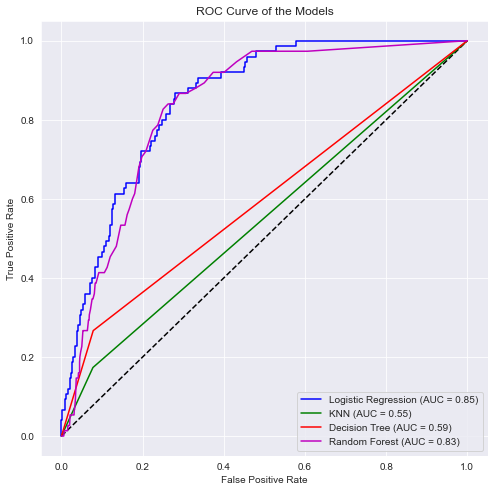

In [75]:
'''Plotting the ROC Curve of the Models'''

# put the models in a list
models = [lr_best, knn_best, dt_best, rfc_best]
colors = ['b', 'g', 'r', 'm']
labels = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')

for i in range(len(models)):
    y_pred_prob = models[i].predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label='%s (AUC = %0.2f)' % (labels[i], roc_auc))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the Models')
plt.legend(loc="lower right")
plt.show()

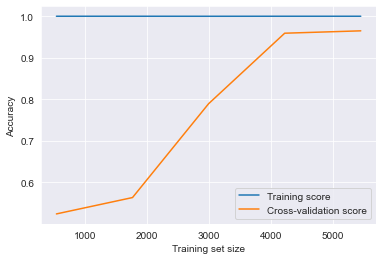

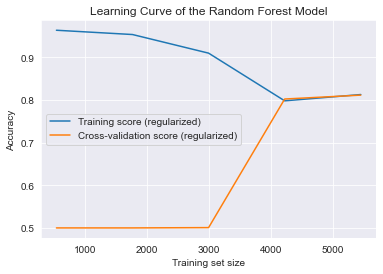

In [76]:
""" Monitoring the learning curve of the Random Forest Model"""

# Train the classifier
rfc_best.fit(X_train_resampled, y_train_resampled)

# Step 4: Monitor learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc_best, X_train_resampled, y_train_resampled, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 5: Apply regularization (in this case, limit the depth of the trees)
clf_regularized = RandomForestClassifier(max_depth=3, random_state=42)
clf_regularized.fit(X_train_resampled, y_train_resampled)

# Check the performance of the regularized model
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(clf_regularized, X_train_resampled, y_train_resampled, cv=5)

train_scores_mean_reg = np.mean(train_scores_reg, axis=1)
test_scores_mean_reg = np.mean(test_scores_reg, axis=1)

plt.plot(train_sizes_reg, train_scores_mean_reg, label='Training score (regularized)')
plt.plot(train_sizes_reg, test_scores_mean_reg, label='Cross-validation score (regularized)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve of the Random Forest Model')
plt.legend()
plt.show()

__Observation:__ The model is overfitting on the train data and the cross-validation score increases as the training size increases which is a good sign that the model is generalizing well to new data. The training score decreasing as the training size increases is expected because of the regularization, and the increasing cross-validation score indicates in its ability to generalize to new data.